In [113]:
import json
import urllib 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme as gev
import scipy.stats as stats
import pandas as pd
import datetime 

# Baltimore

In [92]:
county='WashDC'
#county='Baltimore_'

In [146]:
# Hard Code params with proper names
# at the
params_dict = {'42101': 'CarbonMonoxide', 
               '42401': 'SulfurDioxide', 
               '42602': 'NitrogenDioxide', 
               '44201': 'Ozone', 
               '88101': 'PM2.5LocalConditions'}
params_units = {'42101': 'Parts per million', 
                '42401': 'Parts per billion', 
                '42602': 'Parts per billion', 
                '44201': 'Parts per million', 
                '88101': 'Micrograms/cubic meter (LC)'}

In [94]:
def readAndDisplayFile(c,p,y):
    f_name = '../Anjali/data/'+c+p+'_'+y+'.json'
    #print(f_name)
    with open(f_name) as json_file:
        data = json.load(json_file)
        #print(data)
        df = pd.DataFrame.from_dict(data['Data'])
        #print(df.columns)
        if (df.size != 0) :
            # get only the needed cols out of 30+ columns
            df = df[['date_local','arithmetic_mean','units_of_measure']]

            # agggregate by date so that we have one value per day
            df = df.groupby('date_local').mean().reset_index()
        return df;

In [95]:
def readAndDisplayFileYearRange(c,px,ya,yb):
    #print(c,px,ya,yb)
    # Create Empty DF
    df_ab = pd.DataFrame()
    for y in range(ya,yb):
        df1 = readAndDisplayFile(c,px,str(y));
        df_ab = df_ab.append(df1,ignore_index=True)
    return df_ab
    
#df = readAndDisplayFile('Baltimore','p','2011');

2001 2006


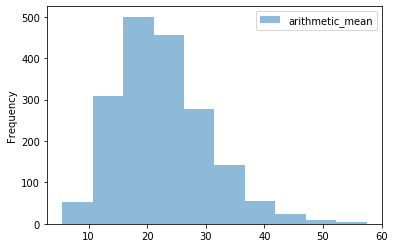

2006 2011


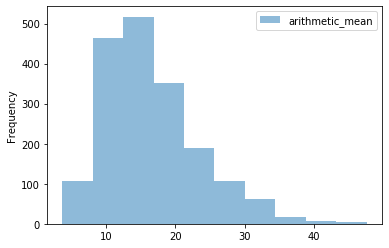

2011 2016


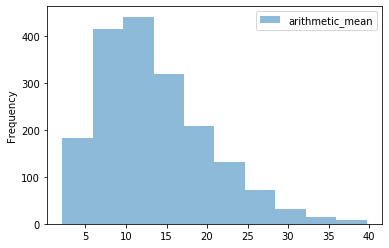

In [147]:
p='42602'
for i in range(2001,2016,5):
    print(i,i+5)
    df =  readAndDisplayFileYearRange(county,p,i,i+5)
    df.plot.hist(alpha=0.5)
    #df.boxplot()
    plt.show()

2016 2021


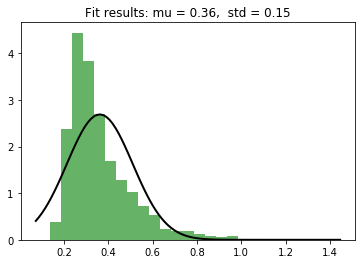

In [144]:
p='42101'
for i in range(2016,2019,5):
    print(i,i+5)
    df =  readAndDisplayFileYearRange(county,p,i,i+4)
    data = df['arithmetic_mean'].to_numpy()
    # Fit a normal distribution to the data:
    mu, std = stats.norm.fit(data)

    # Plot the histogram.
    plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)
    plt.show()
    break


42101 CarbonMonoxide
42401 SulfurDioxide
42602 NitrogenDioxide
44201 Ozone
88101 PM2.5LocalConditions


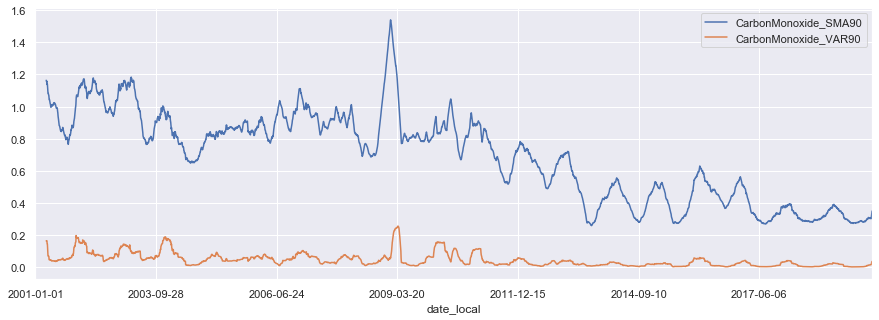

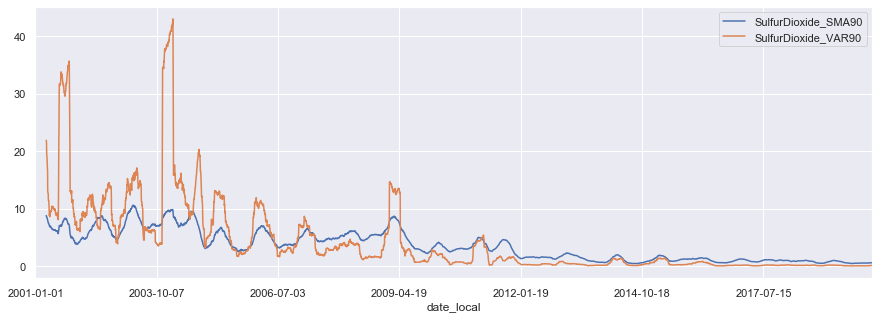

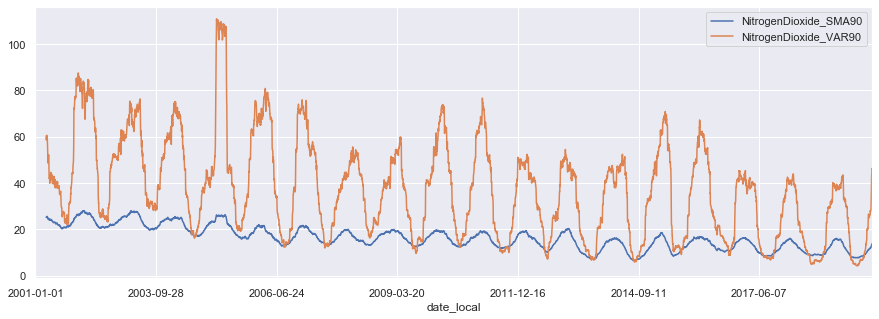

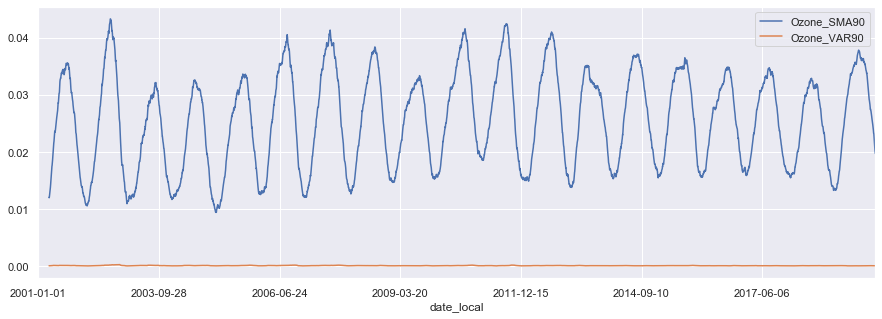

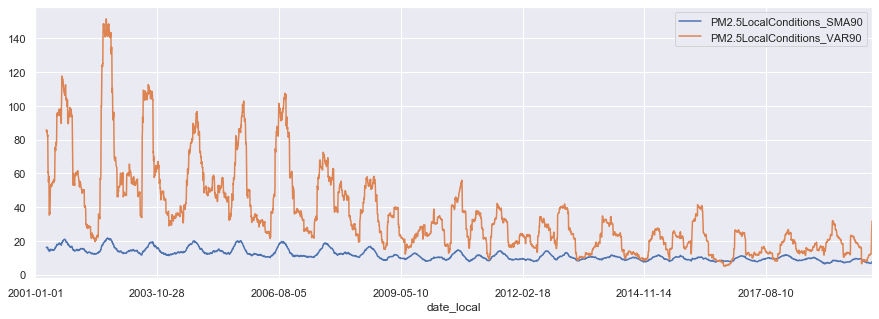

In [168]:
# For each Pollutent, read the data into DFs
for p in params_dict.keys():
    print(p, params_dict[p])
    pn=params_dict[p]

    df = readAndDisplayFileYearRange(county,p,2001,2020)    
    df.columns = ['date_local', params_dict[p]]
    df[pn+'_SMA90'] = df.iloc[:,1].rolling(window=90).mean()
    df[pn+'_VAR90'] = df.iloc[:,1].rolling(window=90).var()
    df = df.drop([pn],axis=1)
    df.groupby('date_local').mean().plot(figsize=(15,5))



In [148]:
def dayofyear():
    x = datetime.date(2019, 4, 13)
    y = datetime.date(2019,4,14)
    one_day = y-x
    num_days = datetime.date(2011, 12, 31) - datetime.date(2010, 1, 1)
    begin = datetime.date(2010, 1, 1)
    end = datetime.date(2011, 12, 31)
    for d in range(0, num_days.days):
        newDate = (str(begin + (d*one_day)))
        print(newDate)
    return newDate

#dayofyear()

In [161]:
df_master = {}

for p in params_dict.keys():
    print(p, params_dict[p])
    df = readAndDisplayFileYearRange(county,p,2001,2020)    
    #df.columns = ['date_local', params_dict[p]]
    df_master[p] = df;   


42101 CarbonMonoxide
42401 SulfurDioxide
42602 NitrogenDioxide
44201 Ozone
88101 PM2.5LocalConditions


##  90 Day Moving Averages

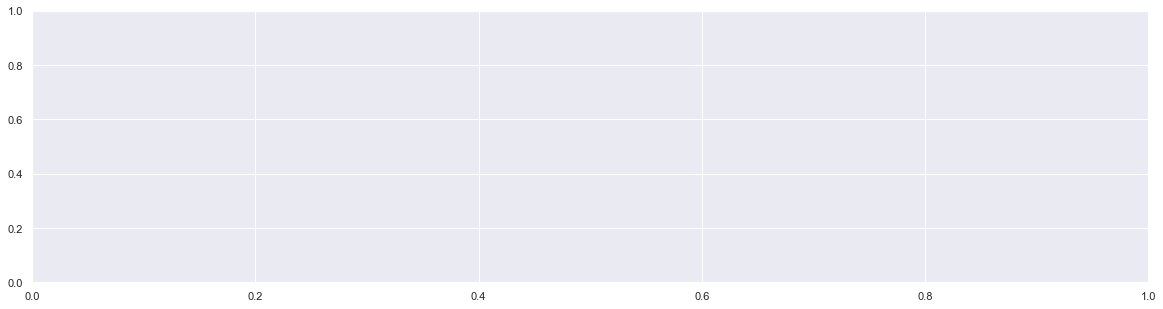

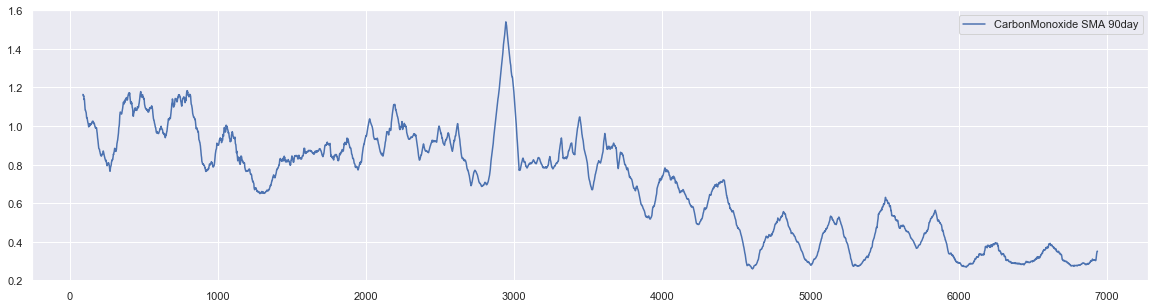

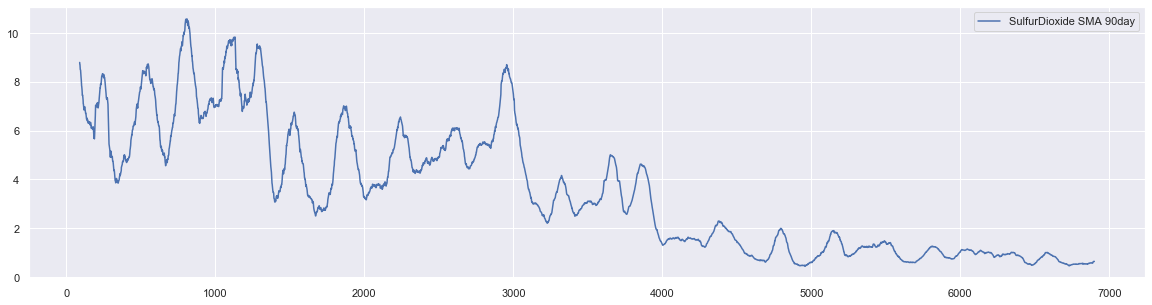

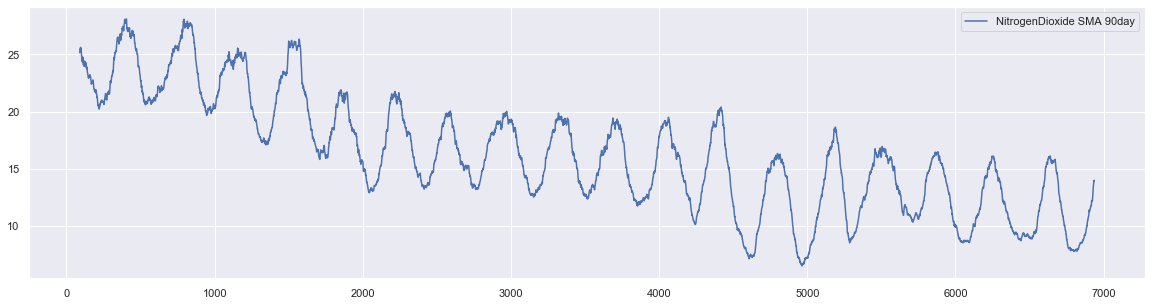

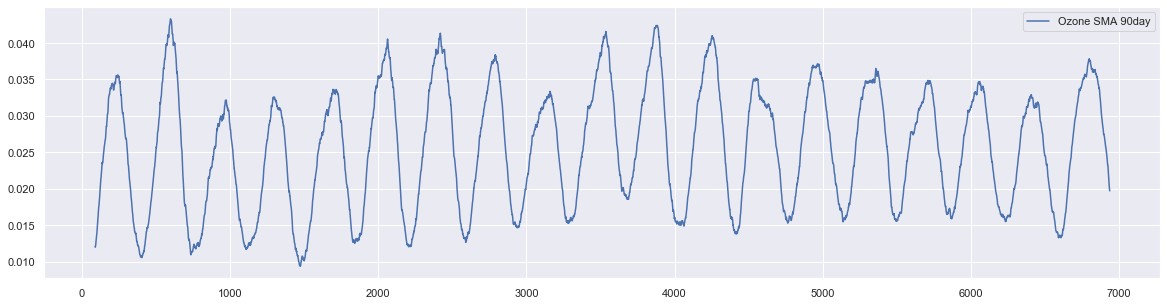

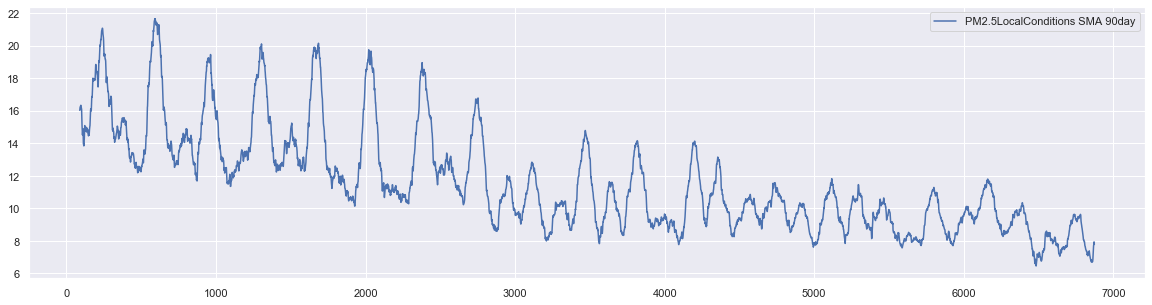

In [162]:
plt.figure(figsize=[20,5])
plt.grid(True)
for p in params_dict.keys():
    pn=params_dict[p]
    dfx = df_master[p]
    #dfx.set_index('date_local',drop=True,inplace=True)
    dfx[pn+'_SMA90'] = dfx.iloc[:,1].rolling(window=90).mean()
    plt.figure(figsize=[20,5])
    plt.grid(True)
    plt.plot( dfx[pn+'_SMA90'],label=pn+' SMA 90day')
    plt.legend(loc='best')

In [163]:
def combineParamCols(ya,yb):
    x = datetime.date(2019, 1, 1)
    y = datetime.date(2019,1,2)
    one_day = y-x

    begin = datetime.date(ya, 1, 1)
    end = datetime.date(yb, 12, 31)
    num_days = end - begin
    print(begin, end)
    data_master = {}
    data_master['date_local'] = []
    for p in params_dict.keys():
        data_master[p] = []

    df_new = pd.DataFrame(data_master)            

    for d in range(0, num_days.days):
        new_date = str(begin + (d*one_day))
        data_master['date_local'].append(new_date)
        for p in params_dict.keys():
            df = df_master[p]
            try:
                val = df[df.date_local==new_date]['arithmetic_mean'].values[0]
                #print(new_date,p, val)
                data_master[p].append(val)
                #print (data_master[p])
            except:
                data_master[p].append(0) #### TBD to think about missing data later 

    return pd.DataFrame(data_master)           


In [164]:
#y=2011
#df_comb = combineParamCols(y,y)
#corrmat = df_comb.corr()
yrly_corrs = {}    
for y in range(2001, 2020):
    df_comb = combineParamCols(y,y)
    yrly_corrs[y] = df_comb.corr()
    


2001-01-01 2001-12-31
2002-01-01 2002-12-31
2003-01-01 2003-12-31
2004-01-01 2004-12-31
2005-01-01 2005-12-31
2006-01-01 2006-12-31
2007-01-01 2007-12-31
2008-01-01 2008-12-31
2009-01-01 2009-12-31
2010-01-01 2010-12-31
2011-01-01 2011-12-31
2012-01-01 2012-12-31
2013-01-01 2013-12-31
2014-01-01 2014-12-31
2015-01-01 2015-12-31
2016-01-01 2016-12-31
2017-01-01 2017-12-31
2018-01-01 2018-12-31
2019-01-01 2019-12-31


In [165]:
yrly_corrs[2001]

,42101,42401,42602,44201,88101
42101,1.000000,0.230901,0.569944,-0.417618,0.299938
42401,0.230901,1.000000,0.286577,0.058727,0.311558
42602,0.569944,0.286577,1.000000,-0.290942,0.439606
44201,-0.417618,0.058727,-0.290942,1.000000,0.192789
88101,0.299938,0.311558,0.439606,0.192789,1.000000


## Simple pair plots among all pollutents

2015-01-01 2015-12-31


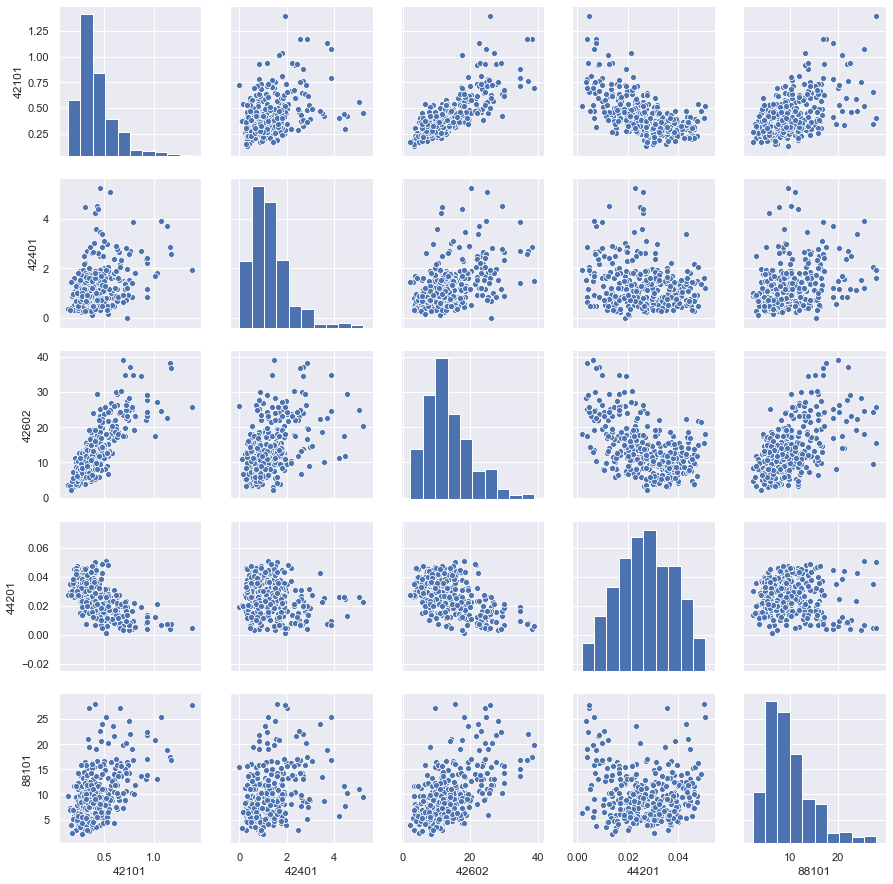

In [166]:
df_comb = combineParamCols(2015,2015)
sns.set()
cols = params_dict.keys()
sns.pairplot(df_comb[cols], height=2.5)
#plt.show()

## Yearly Correlation between pollutents 

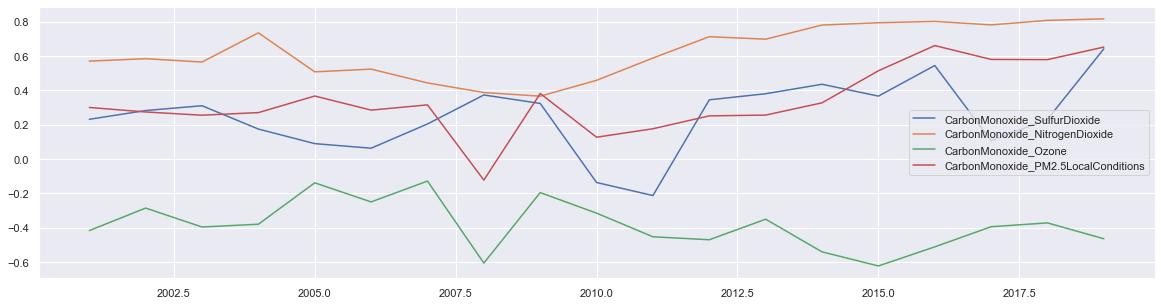

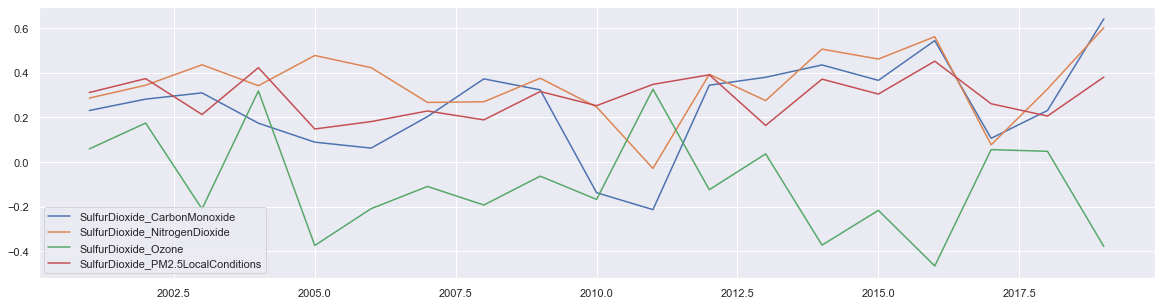

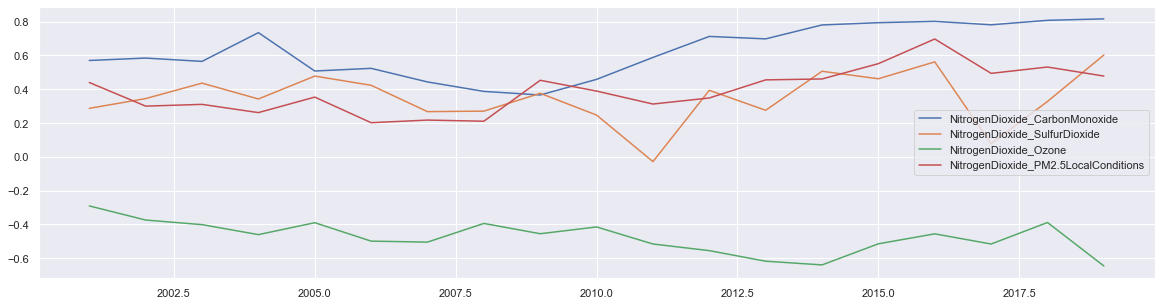

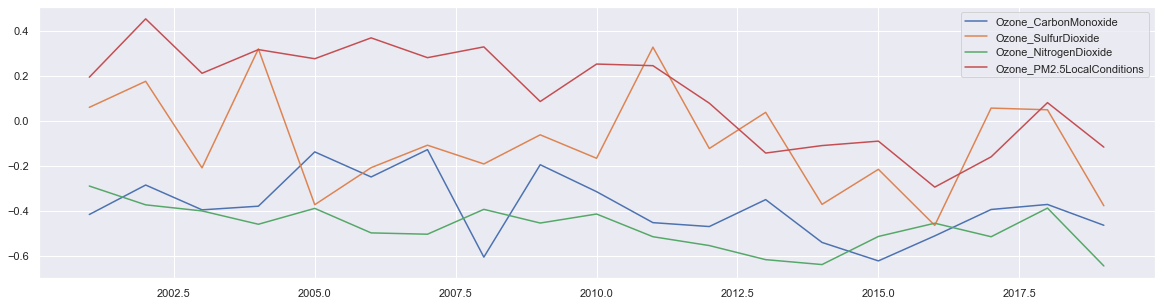

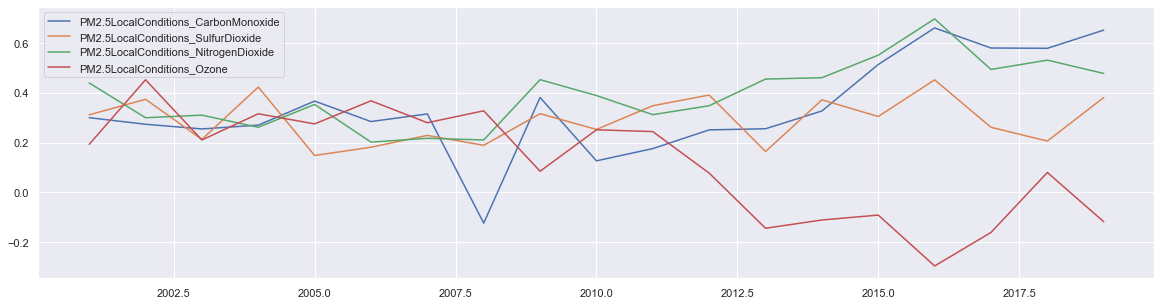

In [167]:
corr_dict = {}
x_ax = []
for y in range(2001, 2020):
    x_ax.append(y)


for pa in params_dict.keys():
    per_par_dict = {}
    corr_dict[pa]=per_par_dict
    plt.figure(figsize=(20,5)) #  width, height

    for pb in params_dict.keys():
        if pa == pb:
            continue
        per_par_dict[pb] = []
        for y in range(2001, 2020):
            per_par_dict[pb].append(yrly_corrs[y][pa][pb])
        lbl = params_dict[pa]+'_'+params_dict[pb]
        plt.plot(x_ax,per_par_dict[pb],label=lbl)
    plt.legend(loc='best')
    plt.show()

#corr_dict

## GEV PDF - work in progress

(-0.5112526217910922, 2.844272843424296, 1.0813536634426404)
(-0.4782309664121023, 2.382512431418828, 0.7866886978819627)
(-0.03560758956759908, 9.081264487424363, 4.593410317479557)


C:\Users\ksama_3n8exwu\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2402: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


(1.52856318215746, 0.0273657952731248, 0.06079318139634372)
(0.044954139716238864, 6.227586471477782, 3.9675846283494494)


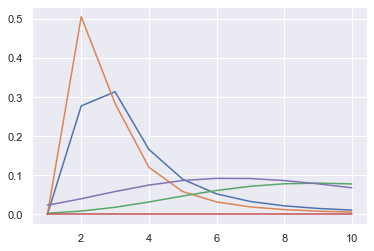

In [18]:
for p in params_dict.keys():
    df_10 = readAndDisplayFileYearRange(county,p,2010,2020)
    dataN = df_10['arithmetic_mean'].tolist()
    t = np.linspace(1,10,10)
    fit = gev.fit(dataN,loc=3)
    pdf = gev.pdf(t, *fit)
    plt.plot(t, pdf)
    #plt.plot(t, dataN, "o")
    print(fit)
